## Load Libraries dan Datasets

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from category_encoders import MEstimateEncoder

from sklearn.model_selection import *
from catboost import *
from xgboost import *
from lightgbm import *

from shap import TreeExplainer, summary_plot, plots
import eli5
from eli5.sklearn import PermutationImportance

In [29]:
train = pd.read_csv('the_final_train.csv')

## Feature Engineering

Encode fitur city

In [30]:
X_encode = train['city']
y_encode = train['rain_sum (mm)']

encoder = MEstimateEncoder(cols=['city'], m=5.0)
encoder.fit(X_encode, y_encode)

train['city'] = encoder.transform(train['city'])

## Validasi

Split menjadi train dan validation sets

In [31]:
X = train.drop(['rain_sum (mm)'], axis=1)
y = train['rain_sum (mm)']
cv = KFold(n_splits=3, shuffle=True, random_state=42)

Daftar model

In [32]:
models = [
    ['XGB', XGBRegressor()], 
    ['CatBoost', CatBoostRegressor(logging_level='Silent')], 
    ['LGBM', LGBMRegressor()], 
    ['GradientBoost', GradientBoostingRegressor()], 

]

Dilakukan cross validation

In [33]:
scoring = 'neg_mean_squared_error'
for name, current_model in models:
    print(name)
    error = -cross_val_score(estimator=current_model, X=X, y=y, cv=cv, scoring=scoring)
    print(error)
    print(error.mean())
    print('')

XGB
[18.07413407 20.58766564 22.03854764]
20.23344911882078

CatBoost
[15.68795799 17.43250992 18.75798332]
17.292817074045647

LGBM
[17.00992446 18.62785313 20.67474692]
18.770841501305952

GradientBoost
[19.07401817 20.98455246 21.44272538]
20.50043200461064



Cek tingkat kepentingan fitur

In [7]:
def ShapImportance(X, y, model):
    '''
    Fungsi berguna untuk mengecek tingkat kepentingan fitur
    menggunakan SHAP. Fungsi akan mengembalikan output
    berupa plot tingkat kepentingan fitur dan 
    list berisi nama fitur terurut dari yang paling penting
    '''
    
    fitted = model.fit(X, y)
    explainer = TreeExplainer(fitted)
    values = explainer.shap_values(X)
    
    summary_plot(values, X)
    
    df = pd.DataFrame(np.abs(values), columns=X.columns).mean()
    df = df.sort_values(ascending=False)
    
    return df.index.tolist()

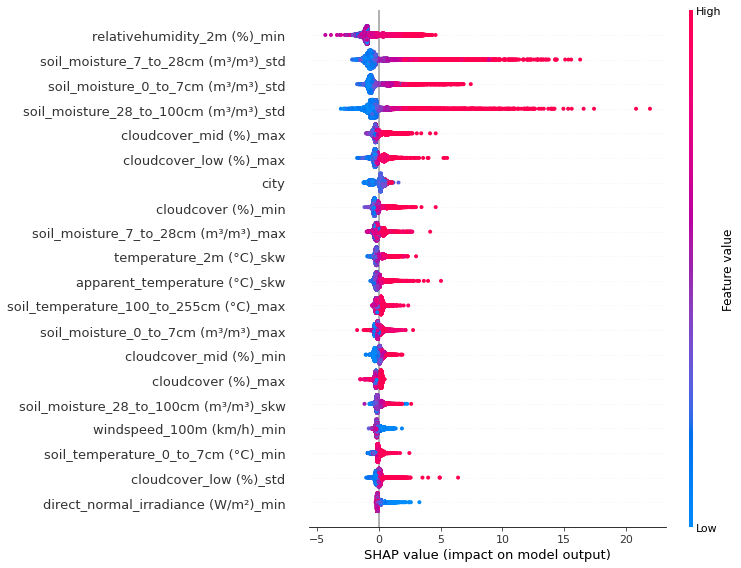

In [8]:
model = CatBoostRegressor(logging_level='Silent')
top = ShapImportance(X, y, model)

87 fitur itu banyak dan lumayan gede computational cost-nya. Maka dari itu, dilakukan feature selection untuk menentukan jumlah fitur yang optimal.

In [9]:
def FeaturesSelection(X, y, top, model, cv, scoring):
    '''
    Fungsi ini berguna untuk melakukan validasi secara berulang
    dengan jumlah fitur yang berbeda. Berikut adalah contohnya:
    Misalkan n adalah total fitur independen suatu dataset, maka
    # Perulangan 1: Validasi data dengan n fitur
    # Perulangan 2: Validasi data dengan n-1 fitur
    # Perulangan 3: Validasi data dengan n-2 fitur
    dst.
    Variabel top adalah fitur yang sudah terurut tingkat 
    kepentingannya.
    '''
    
    start = len(top)
    stop = 1
    step = -1
    
    data = []
    
    for i in range(start, stop, step):
        current_data = {}
        current_data['Top n-features'] = i
        X_top = X[top[:i]]
        
        scores = -cross_val_score(model, X_top, y, cv=cv, scoring=scoring)
        current_data['MSE'] = '{:.3f}'.format(scores.mean())
        data.append(current_data)
        
    df = pd.DataFrame(data)
    df = df.sort_values('MSE', ascending=True)
    df = df.reset_index(drop=True)
    
    return df

Ternyata, MSE paling optimal diberikan oleh dataset dengan 18 fitur independen

Ambil 18 fitur tersebut

In [10]:
optimal = top[:37]

In [14]:
optimal

['relativehumidity_2m (%)_min',
 'soil_moisture_7_to_28cm (m³/m³)_std',
 'soil_moisture_0_to_7cm (m³/m³)_std',
 'soil_moisture_28_to_100cm (m³/m³)_std',
 'cloudcover_mid (%)_max',
 'cloudcover_low (%)_max',
 'city',
 'cloudcover (%)_min',
 'soil_moisture_7_to_28cm (m³/m³)_max',
 'temperature_2m (°C)_skw',
 'apparent_temperature (°C)_skw',
 'soil_temperature_100_to_255cm (°C)_max',
 'soil_moisture_0_to_7cm (m³/m³)_max',
 'cloudcover_mid (%)_min',
 'cloudcover (%)_max',
 'soil_moisture_28_to_100cm (m³/m³)_skw',
 'windspeed_100m (km/h)_min',
 'soil_temperature_0_to_7cm (°C)_min',
 'cloudcover_low (%)_std',
 'direct_normal_irradiance (W/m²)_min',
 'soil_moisture_0_to_7cm (m³/m³)_min',
 'soil_moisture_100_to_255cm (m³/m³)_min',
 'cloudcover_low (%)_min',
 'windspeed_10m (km/h)_max',
 'soil_moisture_7_to_28cm (m³/m³)_min',
 'soil_moisture_0_to_7cm (m³/m³)_skw',
 'soil_moisture_100_to_255cm (m³/m³)_max',
 'soil_temperature_28_to_100cm (°C)_min',
 'relativehumidity_2m (%)_std',
 'diffuse_radia

In [11]:
params = {'learning_rate': 0.0608149078944185, 
          'random_strength': 12, 
          'l2_leaf_reg': 3.722661696388482, 
          'bagging_temperature': 0.29013781647118064, 
          'iterations': 1900}

In [16]:
from sklearn.ensemble import *

In [26]:
models = [
    ['LGBM', LGBMRegressor()], 
   ['XGB', XGBRegressor()], 
    ['Ext', ExtraTreesRegressor()], 
]

In [27]:
scoring = 'neg_mean_squared_error'
for name, current_model in models:
    print(name)
    error = -cross_val_score(estimator=current_model, X=X[optimal], y=y, cv=cv, scoring=scoring)
    print(error)
    print(error.mean())
    print('')

LGBM
[16.50430672 18.08168396 20.29548802]
18.2938262339629

XGB
[18.05472968 19.68163202 22.40466199]
20.047007896302258

Ext
[15.64142762 17.68667919 20.16314296]
17.830416590996162

